In [1]:
%load_ext autoreload
%autoreload 2

## 数据加载

该如何加载这些数据呢？首先我们肯定能确认：图像和它对应的掩码肯定是成对出现的。

按照我的习惯，我会事先将所有图像和掩码的路径都写在一个metadata.csv中，这样可以方便地读取。

你可以展开下方的cell运行，得到metadata.csv

In [2]:
import os
import pandas as pd

# 指定根文件夹路径
root_folder = 'lgg-mri-segmentation/kaggle_3m'

# 列表用于存储image和mask路径
data = {'image_path': [], 'mask_path': []}

# 遍历根文件夹下的所有子文件夹
for sub_folder in os.listdir(root_folder):
    sub_folder_path = os.path.join(root_folder, sub_folder)

    # 检查是否为文件夹
    if os.path.isdir(sub_folder_path):
        # 遍历子文件夹中的所有文件
        for file_name in os.listdir(sub_folder_path):
            if file_name.endswith('.tif') and '_mask' not in file_name:
                # 获取切片路径
                slice_path = os.path.join(sub_folder_path, file_name)

                # 获取对应的掩膜文件路径
                base_name = file_name.replace('.tif', '')
                mask_file_name = base_name + '_mask.tif'
                mask_path = os.path.join(sub_folder_path, mask_file_name)
                
                # 仅当掩膜文件存在时，记录图像和掩膜路径
                if os.path.exists(mask_path):
                    data['image_path'].append(slice_path)
                    data['mask_path'].append(mask_path)

# 创建DataFrame并写入CSV文件
df = pd.DataFrame(data)
csv_output_path = os.path.join(root_folder, 'metadata.csv')
df.to_csv(csv_output_path, index=False)

print(f"metadata.csv 已保存到: {csv_output_path}")


metadata.csv 已保存到: lgg-mri-segmentation/kaggle_3m/metadata.csv


于是我们得到了[lgg-mri-segmentation/kaggle_3m/metadata.csv](lgg-mri-segmentation/kaggle_3m/metadata.csv)

接下来我们构建dataset和dataloader

他们有什么不同呢？Personally，dataset是一个将原始文件进行汇集的`东西`，可以说，dataset里获得到的文件还是原来的那个样子，因为dataset不过是个中介而已：作用是负责将原始数据组织成可用于模型训练和验证的格式。它不会处理批量加载或打乱顺序等操作，只是单独地获取数据样本。

而dataloader则是中介之后，将文件输送给模型的`传送带`了，你知道，模型只看得懂张量，dataloader就负责将我们手头上的文件变成张量，然后通过迭代访问送给模型。

当然，你也可以一次性在一个dataloader里完成所有这些任务，都无所谓，无非形式之变。

我在此使用我最喜欢的`pytoch lightning`中的dataloader变体`datamodule`外加dataset进行示范。

In [ ]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import pytorch_lightning as pl
from torchvision import transforms

# 自定义 PyTorch Dataset
class BrainLesionDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data.iloc[idx]['image_path']
        mask_path = self.data.iloc[idx]['mask_path']
        
        # 打开图像和掩膜
        image = Image.open(image_path).convert('L')
        mask = Image.open(mask_path).convert('L')  # 掩膜为灰度图像

        # 如果有transform，应用到图像和掩膜
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask.long() # 强调一下要整数不要浮点数

# PyTorch Lightning DataModule
class BrainLesionDataModule(pl.LightningDataModule):
    def __init__(self, csv_file, batch_size=16, num_workers=4, transform=None, split_ratio=(0.6, 0.2, 0.2), seed=42):
        super().__init__()
        self.csv_file = csv_file
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.transform = transform
        self.split_ratio = split_ratio  # 训练、验证和测试集的划分比例
        self.seed = seed
        self.generator = torch.Generator().manual_seed(seed)

    # 准备数据集
    def setup(self, stage=None):
        # 创建完整的数据集
        full_dataset = BrainLesionDataset(self.csv_file, transform=self.transform)

        # 计算每个数据集的大小
        dataset_size = len(full_dataset)
        train_size = int(self.split_ratio[0] * dataset_size)
        val_size = int(self.split_ratio[1] * dataset_size)
        test_size = dataset_size - train_size - val_size

        # 使用 random_split 进行数据集划分
        self.train_dataset, self.val_dataset, self.test_dataset = random_split(full_dataset, [train_size, val_size, test_size], generator=self.generator)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=False)

# 示例的 transform，可以根据任务要求更改
transform = transforms.Compose([
    # transforms.Resize((256, 256)), # 因为已经是256规格，所以在这里我不进行resize，实际上你可以进行128的resize，但请注意resize方法，掩码只适合使用最近邻插值的resize方法
    transforms.ToTensor(),
])


按照Pytorch Lightning的使用规范，我们可以实例化出train_loader/val_loader/test_loader，然后可以检查里面的东西。

In [ ]:
import numpy as np
import os
num_workers = os.cpu_count()
csv_file = 'lgg-mri-segmentation/kaggle_3m/metadata.csv'
# 定义 DataModule，使用自动获得的 num_workers
data_module = BrainLesionDataModule(csv_file, batch_size=16, num_workers=num_workers, transform=transform)

# 检查 DataModule 是否正常工作
data_module.setup()
train_loader = data_module.train_dataloader()

# 打印第一个 batch 的形状
for batch in train_loader:
    images, masks = batch
    print(f"Images shape: {images.shape}, Masks shape: {masks.shape}")
    print(f"Image min&Max: {images.min(), images.max()}, Masks unique: {np.unique(masks)}")
    break


Images shape: torch.Size([16, 1, 256, 256]), Masks shape: torch.Size([16, 1, 256, 256])
Image min&Max: (tensor(0.), tensor(0.9490)), Masks unique: [0 1]


可以看到图像最值和掩码独特值变成了0/1之间，这应该是ToTensor造成的，他会自己识别并normalize

---

## 模型怎么办？

准备好了数据，只欠东风了，那么我如何准备模型？

按我的习惯，就两条路。

1. 你已经有了准备好的模型，那么你需要调查一下这个模型的输入输出是多少，如果你的模型只接受512x512的输入，那么我们目前的256x256的规格就不符合了。你就需要对数据进行resize或者对模型进行修改

2. 你没有准备好的数据，你准备进行freestyle，那么就无所谓了，只需要注意你构建的模型需要契合当前数据的维度

在此我们看到`Images shape: torch.Size([8, 3, 256, 256]), Masks shape: torch.Size([8, 1, 256, 256])`，很容易知道模型的输入要与`Images shape: torch.Size([8, 3, 256, 256])`契合。

那么如果我们进行分割任务，模型的输出势必也要和`Masks shape: torch.Size([8, 1, 256, 256])`相等

这样才能进行对比和loss的计算，不然鸡同鸭讲，成何体统呢

在这里，我们使用UNet进行这个任务；我在此使用来自MONAI的UNet，你应该要用开发者方式来安装它，这样我们就能在日后方便地更改里面的代码。

```bash
git clone https://github.com/Project-MONAI/MONAI.git

cd MONAI/

python setup.py develop
```

我们将要使用**BasicUNet**做一个benchmark，你可以在这里找到它：[BasicUNet](MONAI/monai/networks/nets/basic_unet.py)

你可以看到**BasicUNet的定义**中有这么几个参数是我们需要设置的：

```python
        spatial_dims: int = 3,
        in_channels: int = 1,
        out_channels: int = 2,
        features: Sequence[int] = (32, 32, 64, 128, 256, 32),
        act: str | tuple = ("LeakyReLU", {"negative_slope": 0.1, "inplace": True}),
        norm: str | tuple = ("instance", {"affine": True}),
        bias: bool = True,
        dropout: float | tuple = 0.0,
        upsample: str = "deconv",
```

其中act、norm、bias、upsample我们可以不管，但其它的东西我们要稍后在定义模型时声明。

确认好了模型，我们构建训练流程

In [ ]:
import pytorch_lightning as pl
from monai.losses import DiceCELoss
# !pip install -U torchmetrics # fuck torchmetrics终于加入了分割用的Dice
# from torchmetrics.segmentation import GeneralizedDiceScore # https://lightning.ai/docs/torchmetrics/stable/segmentation/generalized_dice.html
from monai.networks.nets import BasicUNet # 在此，我们将BasicUNet导入进来
from monai.metrics import DiceMetric

import torchvision
from torchvision.transforms import ToPILImage
to_pil = ToPILImage()

class BasicUNetLightning(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = BasicUNet(
            spatial_dims=2,
            in_channels=1,
            out_channels=1,
            features=(32,32,64,128,256,32),
            dropout=0.50,
        )
        self.loss = DiceCELoss()
        self.dice_metric = DiceMetric(include_background=True, reduction="mean")
        
    def forward(self, x):
        return torch.sigmoid(self.model(x))
    
    def training_step(self, batch, batch_idx):
        images, masks = batch
        outputs = self(images)
        loss = self.loss(outputs, masks)
        
        # 对模型输出进行阈值化处理
        thresholded_outputs = (outputs > 0.5).float()
        
        # 计算 Dice 系数
        self.dice_metric(y_pred=thresholded_outputs, y=masks)
        dice_score = self.dice_metric.aggregate().item()
        self.dice_metric.reset()
        
        self.log("train_loss", loss, on_step=True, on_epoch=True, logger=True, prog_bar=True)
        self.log("train_dice", dice_score, on_step=True, on_epoch=True, logger=True, prog_bar=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        images, masks = batch
        outputs = self(images)
        loss = self.loss(outputs, masks)
        
        # 对模型输出进行阈值化处理
        thresholded_outputs = (outputs > 0.5).float()
        
        # 计算 Dice 系数
        self.dice_metric(y_pred=thresholded_outputs, y=masks)
        dice_score = self.dice_metric.aggregate().item()
        self.dice_metric.reset()
        
        self.log("val_loss", loss, on_step=True, on_epoch=True, logger=True, prog_bar=True)
        self.log("val_dice", dice_score, on_step=True, on_epoch=True, logger=True, prog_bar=True)
        
        return loss  # 如果需要返回损失

    def test_step(self, batch, batch_idx):
        images, masks = batch
        outputs = self(images)
        loss = self.loss(outputs, masks)
        
        # 对模型输出进行阈值化处理
        thresholded_outputs = (outputs > 0.5).float()
        
        # 计算 Dice 系数
        self.dice_metric(y_pred=thresholded_outputs, y=masks)
        dice_score = self.dice_metric.aggregate().item()
        self.dice_metric.reset()
        
        self.log("test_loss", loss, on_step=True, on_epoch=True, logger=True, prog_bar=True)
        self.log("test_dice", dice_score, on_step=True, on_epoch=True, logger=True, prog_bar=True)
        
        return loss  # 如果需要返回损失

    def predict_step(self, batch, batch_idx):
        images, masks = batch
        outputs = self(images)
        os.makedirs("predictions", exist_ok=True)
        for i in range(images.size(0)):
            image = to_pil(images[i])
            mask = to_pil(masks[i].float())
            output = to_pil(outputs[i].float())
            combined_image = Image.new("RGB", (image.width * 3, image.height))
            combined_image.paste(image, (0, 0))       # 左边是原图
            combined_image.paste(mask, (image.width, 0)) # 中间是真掩码
            combined_image.paste(output, (image.width * 2, 0)) # 右边是预测掩码
            combined_image.save(f"predictions/prediction_{batch_idx}_{i}.png")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

########################################################################################

import os
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
import pytorch_lightning as pl

# 定义 CSVLogger 的保存目录
save_dir = "UNet_logs"
logger = CSVLogger(save_dir=save_dir, name="UNet")

# 获取 CSVLogger 生成的日志文件夹路径
checkpoint_dir = logger.log_dir
os.makedirs(checkpoint_dir, exist_ok=True)

# 定义检查点回调，将模型保存在 CSVLogger 日志目录中
checkpoint_callback = ModelCheckpoint(
    dirpath=checkpoint_dir,                       # 使用 CSVLogger 的日志目录
    filename="UNet-{epoch:02d}-{val_dice:.4f}",   # 模型文件名格式化
    monitor="val_dice",                           # 监控的指标
    mode="max",                                   # 最大化监控指标
    save_top_k=1,                                 # 仅保存最佳模型
    save_last=True                                # 保存最后一个模型
)

# 定义 Trainer，添加自定义的回调
trainer = pl.Trainer(
    max_epochs=150, # 你可以调
    logger=logger,
    callbacks=[checkpoint_callback],
    # overfit_batches=10,
)

# 训练模型
model = BasicUNetLightning()


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


BasicUNet features: (32, 32, 64, 128, 256, 32).


In [6]:
trainer.fit(model, 
            data_module, 
            # ckpt_path='UNet_logs/UNet/version_29/UNet-epoch=46-val_dice=0.2358.ckpt',
            )
trainer.test(model, data_module)

You are using a CUDA device ('NVIDIA L40S') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | BasicUNet  | 2.0 M  | train
1 | loss  | DiceCELoss | 0      | train
---------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
7.914     Total estimated model params size (MB)
143       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_dice_epoch      │            0.0            │
│      test_loss_epoch      │    1.0451164245605469     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 1.0451164245605469, 'test_dice_epoch': 0.0}]

In [9]:
test_loader = data_module.test_dataloader()
prediction = trainer.predict(model, dataloaders=test_loader,ckpt_path='UNet_logs/UNet/version_33/UNet-epoch=111-val_dice=0.7980.ckpt')
# len(prediction)

Restoring states from the checkpoint path at UNet_logs/UNet/version_33/UNet-epoch=111-val_dice=0.7980.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at UNet_logs/UNet/version_33/UNet-epoch=111-val_dice=0.7980.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

---

接下来我们进行可视化，你可以在plot_tools中查看我这个函数的定义和要求，其中你需要输入的是
1. csv的地址
2. 横轴名称（epoch/step）
3. 数轴名称（这里是list对象，所以要有一个[]）

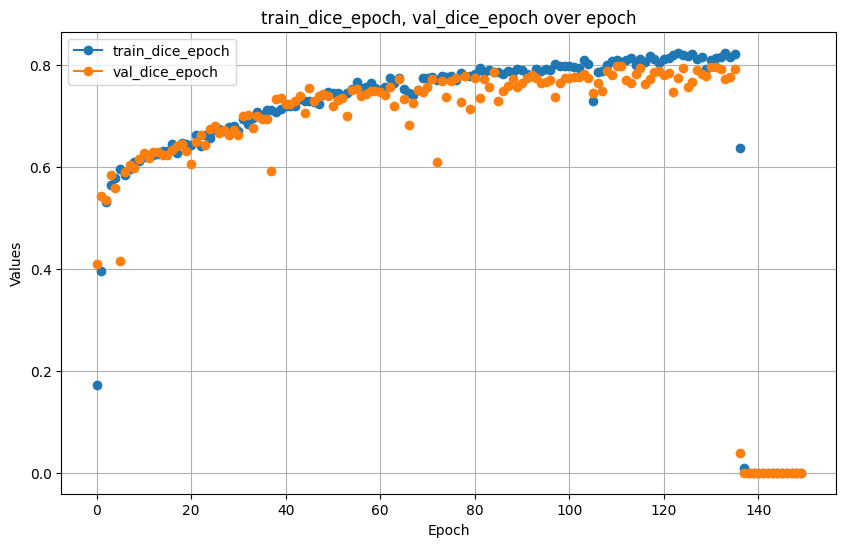

In [1]:
from UNethology.plot_tools import plot_metrics
plot_metrics('UNet_logs/UNet/version_33/metrics.csv', 'epoch', ['train_dice_epoch', 'val_dice_epoch'])